<a href="https://colab.research.google.com/github/hyakuroume/-/blob/main/%E9%81%BA%E4%BC%9D%E5%AD%90%E9%85%8D%E5%88%97%E8%A7%A3%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pytorch_lightning==2.5.1  monai==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 806.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl

import monai
from monai.networks.blocks import Convolution

import h5py

In [3]:
# バージョン確認
print(f" pytorch version : {torch.__version__}\n pytorch lightning : {pl.__version__}\n monai : {monai.__version__}")

 pytorch version : 2.6.0+cu124
 pytorch lightning : 2.5.1
 monai : 1.3.0


In [4]:
# データセットのダウンロード
%%capture
!if [ ! -e seq.h5 ]; then wget https://github.com/japan-medical-ai/medical-ai-course-materials/releases/download/v0.1/seq.h5; fi

In [5]:
!h5dump -n seq.h5

/bin/bash: line 1: h5dump: command not found


In [6]:
# データの確認
def show_hdf5_structure(file_path):
    """HDF5形式のファイル構造を描画する関数

    Args:
        file_path (str): HDF5ファイルのパス

    Prints:
        HDF5ファイルの構造を描画する
    """
    def _print_structure(name, obj):
        """再帰的に構造を出力する"""
        indent = "  " * name.count("/")  # 深さに応じたインデント
        obj_type = "Group" if isinstance(obj, h5py.Group) else "Dataset"
        print(f"{indent}- {name} ({obj_type})")

    with h5py.File(file_path, "r") as hdf:
        print(f"📂 HDF5 structure of '{file_path}':")
        hdf.visititems(_print_structure)


In [7]:
# データの読み込み
with h5py.File("seq.h5", "r") as hf:
    x_train, t_train = hf["train_in"][()], hf["train_out"][()]
    x_val, t_val = hf["valid_in"][()], hf["valid_out"][()]
    x_test, t_test = hf["test_in"][()], hf["test_out"][()]
    label = hf["target_labels"][()]

In [8]:
# データ数の確認
print(f"train : {x_train.shape} {t_train.shape}")
print(f"val   : {x_val.shape} {t_val.shape}")
print(f"test  : {x_test.shape} {t_test.shape}")

train : (5000, 131072, 4) (5000, 1024, 10)
val   : (500, 131072, 4) (500, 1024, 10)
test  : (500, 131072, 4) (500, 1024, 10)


In [9]:
# ラベルの確認
label

array([b'ENCSR000EQH_1_1', b'ENCSR000EKJ_1_1', b'ENCSR000EOM_2_1',
       b'ENCSR257BGZ_2_2', b'ENCSR937UWI_2_2', b'ENCSR000EPP_2_1',
       b'ENCSR000EPD_1_1', b'ENCSR000EQL_2_1', b'ENCSR000EMI_1_1',
       b'ENCSR083STA_1_2'], dtype='|S29')

In [10]:
x_train[0, :10, :]

array([[False,  True, False, False],
       [False, False, False,  True],
       [ True, False, False, False],
       [False, False, False,  True],
       [ True, False, False, False],
       [False, False, False,  True],
       [False, False,  True, False],
       [False, False, False,  True],
       [False, False,  True, False],
       [ True, False, False, False]])

In [11]:
t_train[0, :5, :]

array([[1.034 , 0.    , 0.9663, 1.952 , 2.576 , 0.1135, 0.1472, 0.65  ,
        0.0697, 1.127 ],
       [0.4507, 0.    , 0.    , 3.232 , 3.793 , 0.9253, 0.895 , 0.    ,
        0.    , 2.152 ],
       [0.7114, 0.    , 0.3726, 6.14  , 6.254 , 1.3   , 0.    , 0.    ,
        0.    , 2.117 ],
       [0.929 , 0.    , 0.622 , 4.08  , 2.861 , 1.004 , 0.    , 1.129 ,
        0.    , 2.66  ],
       [0.1335, 0.    , 0.1277, 4.707 , 0.5234, 0.    , 0.4475, 0.629 ,
        0.3198, 2.492 ]], dtype=float16)

<BarContainer object of 1024 artists>

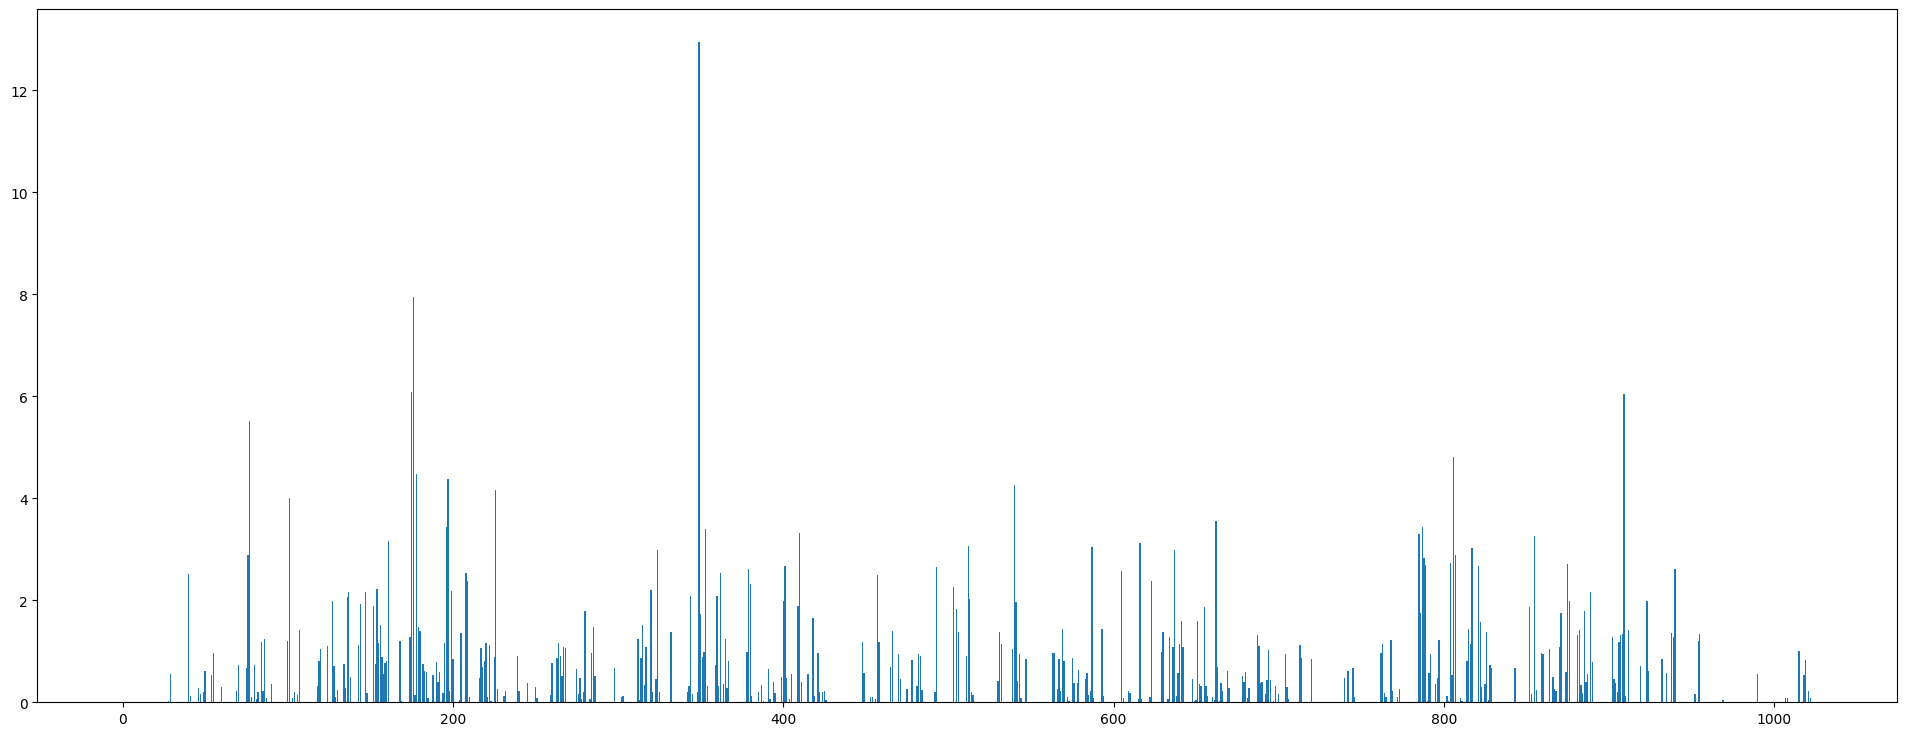

In [12]:
plt.figure(figsize=(24, 9))
value = t_train[0, :, 1]
plt.bar(range(len(value)), value)

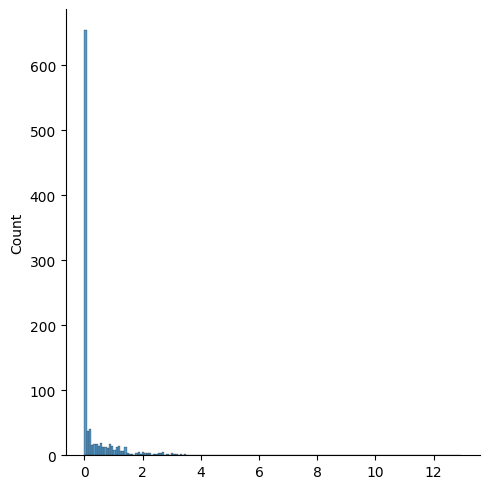

In [13]:
# データの分布をプロット
sns.displot(value)

In [14]:
# データセットクラスの定義
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, x, t):
        self.x = x
        self.t = t[:, :, 1]

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float32).permute(1, 0)
        t = torch.tensor(self.t[idx], dtype=torch.float32)

        return x, t

    def __len__(self):
        return len(self.x)

In [15]:
# シードを固定
pl.seed_everything(0)

# データセットの取得
train = SequenceDataset(x_train, t_train)
val = SequenceDataset(x_val, t_val)
test = SequenceDataset(x_test, t_test)

# バッチサイズの定義
batch_size = 64

# Data Loader を定義
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

INFO:lightning_fabric.utilities.seed:Seed set to 0


In [16]:
# インスタンス化
train = SequenceDataset(x_train, t_train)
x, t = train[0]

In [17]:
x.shape, t.shape

(torch.Size([4, 131072]), torch.Size([1024]))

<BarContainer object of 1024 artists>

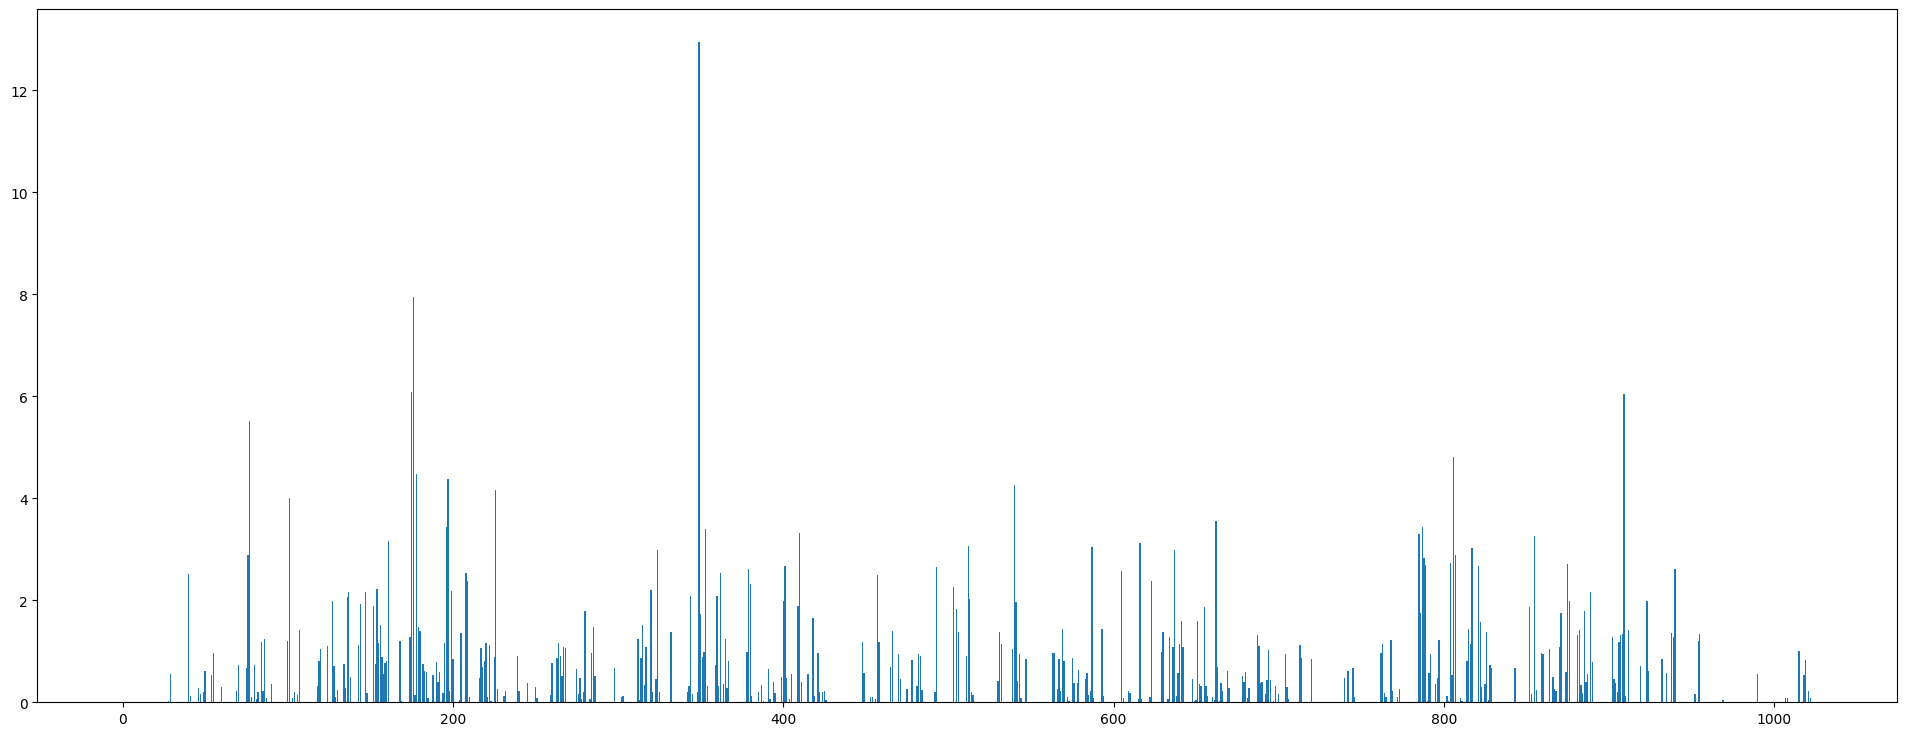

In [18]:
plt.figure(figsize=(24, 9))
plt.bar(range(len(t)), t)

In [19]:
# squeeze_blockのパラメータの定義
squeeze_params = [
    {"in_channels":4, "out_channels":28, "kernel_size":21, "strides":2},
    {"in_channels":28, "out_channels":52, "kernel_size":7, "strides":4},
    {"in_channels":52, "out_channels":76, "kernel_size":7, "strides":4},
    {"in_channels":76, "out_channels":100, "kernel_size":7, "strides":4},
]

In [20]:
# 層の定義
squeeze = nn.Sequential()

for i, p in enumerate(squeeze_params):
    layer = Convolution(
        spatial_dims=1,
        in_channels=p["in_channels"],
        out_channels=p["out_channels"],
        kernel_size=p["kernel_size"],
        strides=p["strides"],
        norm="batch",
        act="ReLU")

    squeeze.add_module(f"conv{i+1}", layer)

squeeze

Sequential(
  (conv1): Convolution(
    (conv): Conv1d(4, 28, kernel_size=(21,), stride=(2,), padding=(10,))
    (adn): ADN(
      (N): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (A): ReLU()
    )
  )
  (conv2): Convolution(
    (conv): Conv1d(28, 52, kernel_size=(7,), stride=(4,), padding=(3,))
    (adn): ADN(
      (N): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (A): ReLU()
    )
  )
  (conv3): Convolution(
    (conv): Conv1d(52, 76, kernel_size=(7,), stride=(4,), padding=(3,))
    (adn): ADN(
      (N): BatchNorm1d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (A): ReLU()
    )
  )
  (conv4): Convolution(
    (conv): Conv1d(76, 100, kernel_size=(7,), stride=(4,), padding=(3,))
    (adn): ADN(
      (N): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (A): ReLU()
    )
  )
)

In [21]:
h = squeeze(x.unsqueeze(0))
h.shape

torch.Size([1, 100, 1024])

## Dilated Blockの定義

In [22]:
# Dilated Blockの各層のパラメータの定義
dilated_conv_params = [
    {'in_channels': 100, 'out_channels': 24, 'kernel_size': 3, 'dilation': 1},
    {'in_channels': 124, 'out_channels': 24, 'kernel_size': 3, 'dilation': 2},
    {'in_channels': 148, 'out_channels': 24, 'kernel_size': 3, 'dilation': 4},
    {'in_channels': 172, 'out_channels': 24, 'kernel_size': 3, 'dilation': 8},
    {'in_channels': 196, 'out_channels': 24, 'kernel_size': 3, 'dilation': 16},
    {'in_channels': 220, 'out_channels': 24, 'kernel_size': 3, 'dilation': 32},
]

In [23]:
# Dilated Blockの設計
dilated_conv = nn.Sequential()

for i, p in enumerate(dilated_conv_params):
        layer = Convolution(
        spatial_dims=1,
        in_channels=p["in_channels"],
        out_channels=p["out_channels"],
        kernel_size=p["kernel_size"],
        dilation=p["dilation"],
        norm="batch",
        act="ReLU")

        dilated_conv.add_module(f"conv{i+1}", layer)

dilated_conv

Sequential(
  (conv1): Convolution(
    (conv): Conv1d(100, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (adn): ADN(
      (N): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (A): ReLU()
    )
  )
  (conv2): Convolution(
    (conv): Conv1d(124, 24, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (adn): ADN(
      (N): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (A): ReLU()
    )
  )
  (conv3): Convolution(
    (conv): Conv1d(148, 24, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (adn): ADN(
      (N): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (A): ReLU()
    )
  )
  (conv4): Convolution(
    (conv): Conv1d(172, 24, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (adn): ADN(
      (N): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (A): ReLU()
    )
  )
  (conv5): Conv

In [24]:
# squeeze Block
h = squeeze(x.unsqueeze(0))

# Dilated Block
hs = [h]

for layer in dilated_conv:
    h = torch.cat(hs, dim=1)
    h = layer(h)
    hs.append(h)

# 結果の統合
h = torch.cat(hs, dim=1)
h.shape

torch.Size([1, 244, 1024])

In [25]:
# 1チャネルへ畳み込み
conv = nn.Conv1d(in_channels=244, out_channels=1, kernel_size=1)

h = conv(h)
h.shape

torch.Size([1, 1, 1024])

In [26]:
h.squeeze().shape

torch.Size([1024])

## ネットワークの定義

In [27]:
class Net(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.squeeze_params =  [
        {"in_channels":4, "out_channels":28, "kernel_size":21, "strides":2},
        {"in_channels":28, "out_channels":52, "kernel_size":7, "strides":4},
        {"in_channels":52, "out_channels":76, "kernel_size":7, "strides":4},
        {"in_channels":76, "out_channels":100, "kernel_size":7, "strides":4},
        ]

        self.dilated_conv_params = [
            {'in_channels': 100, 'out_channels': 24, 'kernel_size': 3, 'dilation': 1},
            {'in_channels': 124, 'out_channels': 24, 'kernel_size': 3, 'dilation': 2},
            {'in_channels': 148, 'out_channels': 24, 'kernel_size': 3, 'dilation': 4},
            {'in_channels': 172, 'out_channels': 24, 'kernel_size': 3, 'dilation': 8},
            {'in_channels': 196, 'out_channels': 24, 'kernel_size': 3, 'dilation': 16},
            {'in_channels': 220, 'out_channels': 24, 'kernel_size': 3, 'dilation': 32},
        ]

        # Squeeze_Block
        self.squeeze = nn.Sequential()

        for i, p in enumerate(squeeze_params):
            layer = Convolution(
                spatial_dims=1,
                in_channels=p["in_channels"],
                out_channels=p["out_channels"],
                kernel_size=p["kernel_size"],
                strides=p["strides"],
                norm="batch",
                act="ReLU")

            self.squeeze.add_module(f"conv{i+1}", layer)

        # Dilated Block
        self.dilated_conv = nn.Sequential()

        for i, p in enumerate(dilated_conv_params):
                layer = Convolution(
                spatial_dims=1,
                in_channels=p["in_channels"],
                out_channels=p["out_channels"],
                kernel_size=p["kernel_size"],
                dilation=p["dilation"],
                norm="batch",
                act="ReLU")

                self.dilated_conv.add_module(f"conv{i+1}", layer)

        # 1チャネルへ畳み込み
        self.conv = nn.Conv1d(in_channels=244, out_channels=1, kernel_size=1)

    def forward(self, x):
        # Squeeze_Block
        h = self.squeeze(x)

        # Dilated Block
        hs = [h]

        for layer in self.dilated_conv:
            h = torch.cat(hs, dim=1)
            h = layer(h)
            hs.append(h)

        # 畳み込み
        h = torch.cat(hs, dim=1)
        h = self.conv(h)
        h = h.squeeze()

        return h

    def r2_score(self, y, t):
        y = torch.exp(y)
        r_n = ((t-y)**2).sum(dim=0)
        r_d = ((t - t.mean(dim=0))**2).sum(dim=0)
        r = 1 - r_n / r_d

        return r.mean()

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)

        loss = F.poisson_nll_loss(y, t)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_r2", self.r2_score(y, t), on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)

        loss = F.poisson_nll_loss(y, t)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_r2", self.r2_score(y, t), on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)

        loss = F.poisson_nll_loss(y, t)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_r2", self.r2_score(y, t), on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        scheduler = torch.optim.lr_schedular.stepLR(optimizer, step_size=800, gamma=0.3)
        return [optimizer], [scheduler]

In [ ]:
# 訓練の実行
pl.seed_everything(0)
net = Net()

trainer = pl.Trainer(max_epochs=10, devices=1, accelerator="gpu", deterministic=True, gradient_clip_val=1.0)
trainer.fit(net, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | squeeze      | Sequential | 94.2 K | train
1 | dilated_conv | Sequential | 69.6 K | train
2 | conv         | Conv1d     | 245    | train
----------------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.656     Total estima

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# テストデータでの検証
results = trainer.test(net, test_loader)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## 結果の可視化

In [ ]:
x, t = test[2]

In [ ]:
net.eval()
net.cpu()

y = net(x.unsqueeze(0))
y = torch.exp(y)

In [ ]:
y.shape, t.shape

In [ ]:
# Numpyに変換
y = y.detach().numpy()
t = t.detach().numpy()

r2_score(t, y)

In [ ]:
# 目標値と予測値の可視化
plt.figure(figsize=(24, 9))
fig_size=plt.rcParams['figure.figsize']

b1 = plt.bar(range(len(t)), t)
b2 = plt.bar(range(len(y)), y)

plt.legend((b1, b2), ('target', 'prediction'))